In [1]:
import os
from matplotlib import pyplot as plt
import librosa
from glob import glob
from scipy.linalg import circulant
from numba import jit

import sys
sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4
from libfmp.c5 import get_chord_labels
import libfmp.c6
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import IPython.display as ipd

from itertools import cycle

plt.rcParams['figure.figsize'] = (19.2, 10.8) #define size of the plot to 1920*1080 pixs square

import scipy.stats
np.set_printoptions(threshold=sys.maxsize)
import logging

In [29]:
"""
finding chords of a song using similarity matrix
"""
logging.basicConfig(filename='sample.log', filemode = 'w', level = logging.INFO)
path = '/Users/Kittipat/Desktop/fypW/Program/Train_test/Train_songs'
files = []
total = 0
count = 0

for file_name in os.listdir(path):
    if os.path.isfile(os.path.join(path, file_name)):
        if '.wav' in file_name:
            files.append(file_name)
            
for items in files:                                                    # initiate for loop for each file name
    all_chord = items.split('_')                                       # for each file name, split _
    logging.debug(f'all_chord = {all_chord}')
    fn_wav = path+'/'+items
    N = 4096
    H = 2048
    X_STFT, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
    fn_ann = os.path.join("/Users/Kittipat/Desktop/fypW/Program/Train_test/Train_songs/label/0_Bm_E_C#m_F#m_Bm_E_A_A_110bpm_คนใจง่าย.csv")
    ann, _ = libfmp.c4.read_structure_annotation(fn_ann)
    color_ann = {'N': [1, 1, 1, 1], 'A': [127/255, 178/255, 16/255, 1], 'A#': [158/255, 178/255, 16/255, 1], 
                 'B': [1, 1, 0, 1], 'C': [1, 0, 0.5, 1], 'C#': [1, 0, 1, 1],
                'D': [1, 0.5, 1, 1],'Dmaj7': [255/255, 4/255, 0, 1], 'Em7': [0, 1, 0.2, 0],
                'F': [1, 0.5, 1, 1],'F#': [255/255, 4/255, 0, 1], 'G': [0, 1, 0.2, 0], 'G#': [1, 0.5, 1, 1]}

    X = X_STFT
    chord_sim, chord_max = libfmp.c5.chord_recognition_template(X, norm_sim='max')
    chord_labels = get_chord_labels(nonchord=False)
    
    for chord in all_chord:                                            # find bpm and split latter part out
        index = all_chord.index(chord)                                 # index of string of each file names                  
        logging.debug(f'index = {index}')                              
        if 'bpm' in chord:                                             # find bpm
            bpm = int(chord.split('b')[0])
            logging.debug(f'bpm = {bpm}')
        if index != 0:
            if chord[0].isdigit():                                     # split the latter part
                list_len = len(all_chord)
                logging.debug(f'list_len = {list_len}')
                del all_chord[index:list_len]
                logging.debug(f'all_chord after del = {all_chord}')
                break
    
    t = (1/(bpm/60))*4                                                 # time for each chord
    ann = []                                                           # annotation matrix for each files
    
    del all_chord[0]
    res = []
    count_arr = np.zeros(24, dtype=int)
    df = libfmp.b.b_annotation.read_csv((path+'/label/'+items.split('.wav')[0] + '.csv'), header=True, add_label=False)
    #no = df.at[0,'end']
    #no = no/0.09284
    #if '=' in all_chord[0]:
    #    special_note = all_chord[0].split('=')
    #    tmp = float(special_note[1])
    #    no = tmp*no
    #no_check = np.arange(no,chord_max.shape[1]+1,no)
    #print(items)
    #print(df)
    no_check = []
    for i in range(df.shape[0]):
        no = df.at[i,'end']
        no = no/0.09284
        no_check.append(no)
    #print(f'{items}, {chord_max.shape[1]}')
    for i in range(chord_max.shape[1]):
        #print(f'{i}, {chord_max.shape[1]}')
        for m in range(24):
            if chord_max[m][i] == 1:
                count_arr[m] += 1
        for n in no_check:
            #print(f'{i}, {round(n)-1}')
            if i == round(n)-1:
                res.append(chord_labels[np.argmax(count_arr)])
                count_arr = np.zeros(24, dtype=int)
                
    #print(res)
    for i in range(len(all_chord)):
        total += 1
        chord = all_chord[i].split('=')[0]
        #print(f'{i}, {len(res)}, {all_chord}')
        if chord[0] == res[i%len(res)][0]:
            if 'maj7' in chord:
                if res[i] == chord[0]:
                    count += 1
                    logging.info(f'maj7, res = {res[i]}, chord = {chord}')
            elif 'm7' in chord:
                if res[i] == chord.split('7')[0]:
                    count += 1
                    logging.info(f'm7 res = {res[i]}, chord = {chord}')
            elif '7' in chord:
                if res[i] == chord[0]:
                    count += 1
                    logging.info(f'7 res = {res[i]}, chord = {chord}')
            else:
                if res[i] == chord:
                    count += 1
                    logging.info(f'res = {res[i]}, chord = {chord}')

print(f'total = {total}, correct = {count}')

total = 138, correct = 67


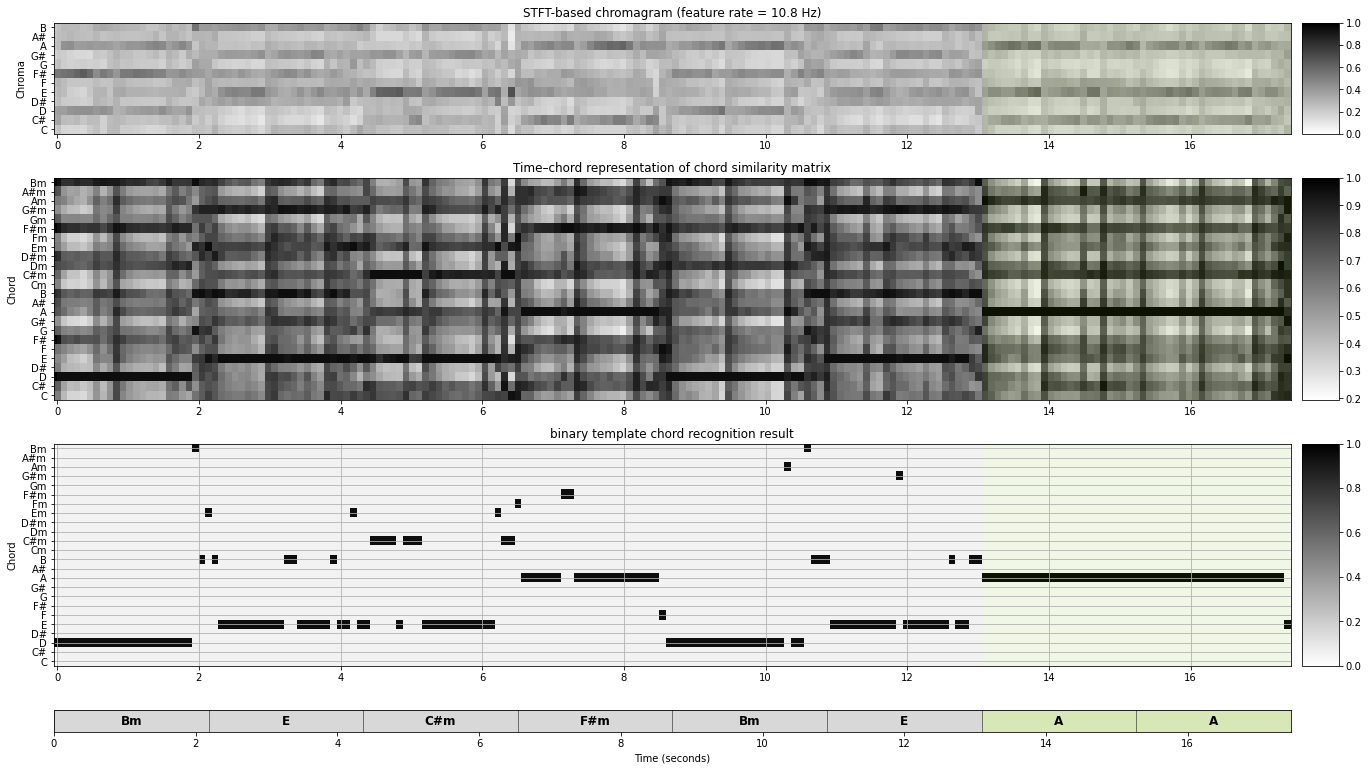

In [5]:
"""
show spectogram and matching result of the tested song, as shown below, all major chords are clear and easier to get right than minor chords
"""
fn_wav = os.path.join("/Users/Kittipat/Desktop/fypW/Program/Train_test/Train_songs/0_Bm_E_C#m_F#m_Bm_E_A_A_110bpm_คนใจง่าย.wav")
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')

fn_ann = os.path.join("/Users/Kittipat/Desktop/fypW/Program/Train_test/Train_songs/label/0_Bm_E_C#m_F#m_Bm_E_A_A_110bpm_คนใจง่าย.csv")
ann, _ = libfmp.c4.read_structure_annotation(fn_ann)
color_ann = {'N': [1, 1, 1, 1], 'A': [127/255, 178/255, 16/255, 1], 'A#': [158/255, 178/255, 16/255, 1], 
             'B': [1, 1, 0, 1], 'C': [1, 0, 0.5, 1], 'C#': [1, 0, 1, 1],
            'D': [1, 0.5, 1, 1],'Dmaj7': [255/255, 4/255, 0, 1], 'Em7': [0, 1, 0.2, 0],
            'F': [1, 0.5, 1, 1],'F#': [255/255, 4/255, 0, 1], 'G': [0, 1, 0.2, 0], 'G#': [1, 0.5, 1, 1]}

X = X_STFT
chord_sim, chord_max = libfmp.c5.chord_recognition_template(X, norm_sim='max')
chord_labels = get_chord_labels(nonchord=False)

cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3, 0.3]}, figsize=(19.2, 10.8))
libfmp.b.plot_chromagram(X, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
libfmp.b.plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels) ))
ax[1, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='binary template chord recognition result',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels) ))
ax[2, 0].set_yticklabels(chord_labels)
ax[2, 0].grid()
libfmp.b.plot_segments_overlay(ann, ax=ax[2, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_segments(ann, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

In [5]:
"""
Matching all 21 parts of songs with similarity matrix and compare the result to label
"""
path = '/Users/Kittipat/Desktop/fypW/Program/Train_test/Train_songs'  # replace with the path to your directory
files = []

for file_name in os.listdir(path):
    if os.path.isfile(os.path.join(path, file_name)):
        if '.wav' in file_name:
            files.append(file_name)
            
all_sim = np.empty([24,0])
all_real = np.empty([0],dtype=int)
chord_labels = get_chord_labels(nonchord=False)
count = 0
for items in files:
    fn_wav = path+'/'+items
    N = 4096
    H = 2048
    X, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
    chord_sim, chord_max = libfmp.c5.chord_recognition_template(X, norm_sim='max')
    all_sim = np.append(all_sim, chord_max, axis=1)
    df = libfmp.b.b_annotation.read_csv((path+'/label/'+items.split('.wav')[0] + '.csv'), header=True, add_label=False)
    all_real = np.append(all_real, np.zeros((chord_max.shape[1]),dtype=int))
    #print(all_real)
    for i in range(df.shape[0]):
        df_start = df.at[i,'start']
        df_end = df.at[i,'end']
        first_frame = round(df_start/0.09284)
        last_frame = round(df_end/0.09284)
        chord_each = df.at[i,'label']
        if 'maj7' in chord_each:
            chord = chord_each[0]
        elif 'm7' in chord_each:
            chord = chord_each[0] + chord_each[1]
        elif '7' in chord_each:
            chord = chord_each[0]
        else:
            chord = chord_each
        for n in range(first_frame, last_frame):
            #print(n)
            ind = chord_labels.index(chord)
            if (n+count)<len(all_real):
                all_real[n+count] = ind
                #print(ind)
            #print(all_real[i])
    count += chord_max.shape[1]-1

In [16]:
all_sim_ind = np.argmax(all_sim, axis=0)
count = 0
total = 0
for i in range(all_real.size):
    if all_sim_ind[i] == all_real[i]:
        count += 1
    total += 1
    
print(f'total {total}, correct {count}, {count/total}')

total 4798, correct 1817, 0.3786994581075448
